# Analysis of CoG public data

Work with the CoG metadata to look at the variant emergence

Note, the file is slightly too big for GitHub but this one was at:

https://cog-uk-microreact.s3.climb.ac.uk/2021-05-07/cog_metadata_microreact_geocodes_only.csv


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.optimize as op
from numpy import linalg as LA

In [2]:
df = pd.read_csv('./cog_metadata_microreact_geocodes_only.csv', usecols=['adm1','sample_date','lineage'])

In [3]:
df = df[df.adm1=='UK-ENG'].reset_index(drop=True).drop(columns=['adm1'])
df

,sample_date,lineage
0,31/12/2020,B.1.1.7
1,28/11/2020,B.1.177.19
2,04/11/2020,B.1.177.19
3,01/12/2020,B.1.177
4,20/10/2020,B.1.177
...,...,...
325856,03/03/2020,B.1.98
325857,03/03/2020,B.1
325858,02/03/2020,B.1.91
325859,25/02/2020,B.40


In [4]:
def todays(x):
    return np.array((pd.to_datetime(x, format='%d/%m/%Y') - pd.Timestamp("2021-01-01")) // pd.Timedelta('1D'))

In [5]:
days = df['sample_date'].apply(todays)
days

0          -1
1         -34
2         -58
3         -31
4         -73
         ... 
325856   -304
325857   -304
325858   -305
325859   -311
325860   -338
Name: sample_date, Length: 325861, dtype: int64

In [6]:
strains = pd.unique(df['lineage'])
strains[['B.1.617' in s for s in strains]]

array(['B.1.617'], dtype=object)

In [7]:
isi = np.array(df.lineage.values == 'B.1.617')
isi

array([False, False, False, ..., False, False, False])

In [8]:
m = np.max(days)
variant_count = np.zeros(m+1)
wild_count = np.zeros(m+1)
for i in range(0,m+1):
    wild_count[i] = np.sum((days==i) & ~isi)
    variant_count[i] = np.sum((days==i) & isi)

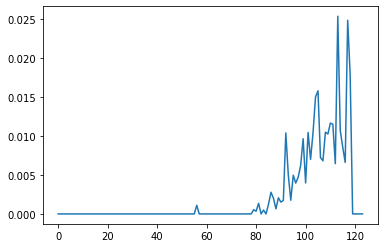

In [12]:
tt = np.arange(0,m+1)
yy = variant_count
nn = variant_count + wild_count
ww = variant_count / wild_count
plt.plot(tt,ww)

<ipython-input-10-2fa328ead07b>:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(tt,np.log(ww/(1.-ww)))


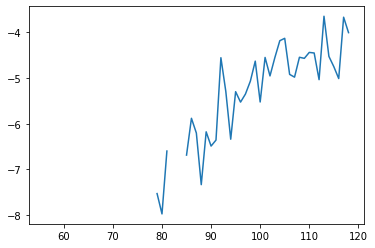

In [10]:
plt.plot(tt,np.log(ww/(1.-ww)))

In [11]:
# TO DO - GP prior fit on logistic scale?

In [16]:
jj = np.arange(80,116)
n = len(jj)
tt = np.arange(0,n)
yy = yy[jj]
nn = nn[jj]
print(yy)
print(nn)

[ 1.  3.  0.  1.  0.  2.  4.  4.  1.  3.  2.  2. 12.  5.  2.  6.  4.  4.
  5.  6.  3. 10.  7. 10. 14. 13.  5.  4. 12.  7. 11. 10.  3.  7.  2.  4.]
[2911. 2210. 1950. 2048. 1717. 1610. 1443. 1988. 1535. 1453. 1322. 1160.
 1167. 1005. 1138. 1214. 1015.  852.  806.  628.  759.  967. 1007.  967.
  947.  836.  696.  591. 1156.  690.  955.  879.  468.  283.  189.  471.]


In [17]:
st.binom.logpmf(yy, nn, yy/nn, loc=0)

array([-0.99982822, -1.49524346,  0.        , -0.99975582,  0.        ,
       -1.30623138, -1.63148862, -1.63186942, -0.9996742 , -1.49488931,
       -1.30609591, -1.30599013, -2.16316744, -1.73780882, -1.30597344,
       -1.82621744, -1.63090237, -1.6305239 , -1.73719143, -1.82389564,
       -1.49394284, -2.07336499, -1.90030309, -2.07336499, -2.23697294,
       -2.19998757, -1.73669813, -1.62948175, -2.16311802, -1.89869319,
       -2.11966827, -2.07284185, -1.49270831, -1.89127477, -1.30153834,
       -1.62861348])

In [59]:
def logodds(p):
    return np.log(p/(1.0-p))

def logistic(x):
    return (1.0/(1.0+np.exp(-x)))

In [60]:
import sklearn.gaussian_process.kernels as sklk

In [70]:
lell = np.log(1.)
lsig = np.log(100.)
x0 = np.concatenate([np.zeros(n),[lell,lsig]]) # 2.*np.ones(n)
bb = np.concatenate([np.stack([-10*np.ones(n),1*np.ones(n)]).T,np.array([[-5,5],[-5,5]])])

In [71]:
def mynll(x):
    
    pp = logistic(x[0:n])
    lell = x[n]
    lsig = x[n+1]
    
    l1 = -np.sum(st.binom.logpmf(yy, nn, pp, loc=0))
    
    kern = sklk.WhiteKernel(noise_level=1e-6) + (np.exp(lsig)**2)*sklk.RBF(length_scale=np.exp(lell))
    Kmat = kern(X=np.atleast_2d(tt).T)
    l2 = -st.multivariate_normal.logpdf(x[0:n], mean=np.zeros(n), cov=Kmat, allow_singular=True)
    
    return l1 + l2

In [72]:
mynll(x0)

27575.49494000498

In [74]:
fout = op.minimize(mynll,x0,method='L-BFGS-B',bounds=bb,options={'maxfun':1000000})
#fout = op.minimize(mynll,x0,method='TNC',bounds=bb,options={'maxfun':1000000})
fout

      fun: -82.14708429467267
 hess_inv: <38x38 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.8282739 ,   7.31845238,   5.01004397,   9.32176226,
         7.41867017,   0.10189467,  -4.45450044,  -3.13365833,
        -0.89468131,  -1.17047848,  -1.53982001,  -1.90783142,
        -4.93311635,  -4.09011565,  -4.29616025,  -4.98148441,
        -1.96577049,   1.12942332,   2.21863134,   0.70800326,
        -0.02816591,  -2.07116814,   0.3871179 ,   1.57212555,
         1.88793053,   2.92382085,   5.52322493,   5.32307925,
         2.31133443,   2.39310369,   2.17727206,   1.50899809,
        -4.47890616, -15.85847836,  -9.50280145,  -6.8357338 ,
        14.42445532,  -4.68410806])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7566
      nit: 132
     njev: 194
   status: 0
  success: True
        x: array([-6.26355682, -6.21672179, -6.16538617, -6.1099469 , -6.05085561,
       -5.98856064, -5.92352508, -5.85623305, -5.78718069, -5.71687199,
      

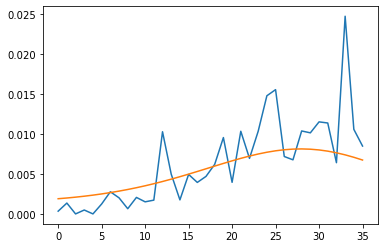

In [78]:
phats = logistic(fout.x[0:n])
plt.plot(tt,yy/nn)
plt.plot(tt,phats)